In [1]:
from pycm import *
from matplotlib import pyplot as plt
from easydict import EasyDict as edict
from module.class_names import class_names
from torchvision import transforms
from torch.nn import functional as F
from module.models import create_model
from module.utils import metrics_report_to_df, save_plot_cm, prec_score, \
                        recc_score, acc_score, fone_score, classification_reports, set_seeds, precision_recall_fscore_support
from pycm import *
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import os
import time
import torch
import numpy as np
import yaml
import glob as glob
import cv2
import argparse

In [2]:
class_names

['Audi A4 2009-2012',
 'Audi A4 2013',
 'Audi A6L 2009',
 'Audi A6L 2012',
 'Audi A8L',
 'Audi Q5',
 'Audi Q7',
 'BMW 3 Series 2013-2014',
 'BMW 5 Series',
 'BMW 530',
 'BMW 7 Series',
 'BMW X1',
 'BMW X3',
 'BMW X5',
 'BYD F0',
 'BYD F3 2007-2011',
 'BYD F6',
 'BYD L3',
 'BYD S6',
 'Buick Encore',
 'Buick Excelle',
 'Buick GL8',
 'Buick GL8 2011-2013',
 'Buick Hideo 2010-13',
 'Buick LaCrosse 2009-2013',
 'Buick Regal 09-11',
 'Buick Yinglang XT',
 'Cadillac SRX',
 "Chang'an Star",
 'Changan Star 2 Generation',
 'Changan Star 6363 Series',
 'Changan Starlight 4500 Series',
 'Changan Starlight SC6345BFA',
 'Changhe Freda',
 'Chery A3 2008',
 'Chery A5',
 'Chery Cowin 2008 Model',
 'Chery E5',
 'Chery Fengyun',
 'Chery QQ 2007-2012',
 'Chery Tiggo 2011 Model',
 'Chevrolet Captiva',
 'Chevrolet Cruze',
 'Chevrolet Epica',
 'Chevrolet Lefeng',
 'Chevrolet Malibu',
 'Chevrolet Sail',
 'Citroen C2',
 'Citroen C4 2009',
 'Citroen C5 2010-2012',
 'Citroen Elysee 2008-2013',
 'Citroen SEGA 201

In [3]:
init = set_seeds()
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(f"Computation device: {device}")

Computation device: cuda:0


In [4]:
def transform(image):
    transformation = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                    std=[0.229, 0.224, 0.225])
            ])
    return transformation(image)

In [5]:
pku_path = f"../Inference/best_models/pku.pth" 

In [6]:
vehicle_id = create_model(model_name = 'efficientnet_v2_s' , num_classes = 200).to(device)
vehicle_id.eval()

[INFO]: Freezing hidden layers...


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [7]:
print(vehicle_id.load_state_dict(torch.load(pku_path, 
                                    map_location=device)['model_state_dict'], 
                                   ))

<All keys matched successfully>


In [8]:
test_path = '../Dataset/Vehicle-ID/val/*/*.jpg'
test_images = glob.glob(test_path, recursive=True)
len(test_images)

29917

In [9]:
from tqdm import tqdm

y_true = []
y_pred  = []
t0 = time.time()
for image_path in tqdm(test_images):
#     print(image_path)
    image = cv2.imread(image_path)
    file_name =  image_path.split(os.path.sep)[-1]
    actual_class_name = image_path.split(os.path.sep)[-2]
    original_image = image.copy()

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width, channel = original_image.shape

    image_tensor = transform(image)
    image_tensor = image_tensor.unsqueeze(0).to(device)

    start_time = time.time()

    with torch.no_grad():      
        outputs = vehicle_id(image_tensor)
      
    end_time = time.time()

    probs = F.softmax(outputs, dim=1)
    conf, classes = torch.max(probs, 1)
    conf_score = float(conf.item())
    class_idx = int(classes.item())
    pred_class_name = str(class_names[int(class_idx)])

    y_true.append(actual_class_name)
    y_pred.append(pred_class_name)
    
#     if actual_class_name == pred_class_name:
#         print(f"[{file_name}] Actual: {actual_class_name} / Prediction: {pred_class_name} ({conf_score})")
#         print(f"[+] Inference Time: {(end_time - start_time)*1000 :.3f} ms.")

100%|██████████| 29917/29917 [32:39<00:00, 15.27it/s]  


In [10]:
print(f"Precision score (weighted): {prec_score(y_true, y_pred, class_names):.4f}")
print(f"Recall score (weighted): {recc_score(y_true, y_pred, class_names):.4f}")
print(f"Accuracy score (weighted): {acc_score(y_true, y_pred):.4f}")
print(f"F1 Score score (weighted): {fone_score(y_true, y_pred, class_names):.4f}")
# print(f"PRSF: {precision_recall_fscore_support(y_true, y_pred)}")
print(f"Clssification report:\n")
print(classification_reports(y_true, y_pred, class_names))

Precision score (weighted): 0.9929
Recall score (weighted): 0.9926
Accuracy score (weighted): 0.9926
F1 Score score (weighted): 0.9920
Clssification report:

                                 precision    recall  f1-score   support

              Audi A4 2009-2012       1.00      0.98      0.99       112
                   Audi A4 2013       0.99      0.99      0.99       334
                  Audi A6L 2009       1.00      1.00      1.00       280
                  Audi A6L 2012       0.99      0.97      0.98        77
                       Audi A8L       1.00      1.00      1.00        66
                        Audi Q5       0.97      1.00      0.98        98
                        Audi Q7       1.00      1.00      1.00        53
         BMW 3 Series 2013-2014       1.00      0.96      0.98        25
                   BMW 5 Series       1.00      0.99      1.00       343
                        BMW 530       1.00      1.00      1.00        26
                   BMW 7 Series       

In [11]:
cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix

array([[110,   0,   0, ...,   0,   0,   0],
       [  0, 332,   0, ...,   0,   0,   0],
       [  0,   0, 279, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ..., 863,   0,   0],
       [  0,   0,   0, ...,   0, 417,   0],
       [  0,   0,   0, ...,   0,   0,  48]])

In [12]:
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) 
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)
FP, FN, TP, TN

(array([ 0.,  2.,  0.,  1.,  0.,  3.,  0.,  0.,  0.,  0.,  3.,  1.,  2.,
         1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  3.,  1.,  1.,  2.,
         0.,  0., 52.,  1.,  4.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0., 17.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,
         1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         2.,  0.,  1.,  0.,  1.,  0.,  0.,  5.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0., 13.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  4.,
         0.,  1.,  0.,  0.,  0.,  0.,  5.,  0.,  0.,  1.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  5.,  0.,  0.,  0.,  3.,  0.,  0.,  2.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.

In [38]:
ACC = (TP+TN)/(TP+FP+FN+TN)
ACC

0.9999257946986663

In [39]:
P = TP/(TP+FP)
P

0.992579469866631

In [40]:
R = TP/(TP+FN)
# sum(R) / 15
R

0.992579469866631

In [16]:
cm = ConfusionMatrix(actual_vector=y_true, predict_vector=y_pred)

In [17]:
cm.classes

['Audi A4 2009-2012',
 'Audi A4 2013',
 'Audi A6L 2009',
 'Audi A6L 2012',
 'Audi A8L',
 'Audi Q5',
 'Audi Q7',
 'BMW 3 Series 2013-2014',
 'BMW 5 Series',
 'BMW 530',
 'BMW 7 Series',
 'BMW X1',
 'BMW X3',
 'BMW X5',
 'BYD F0',
 'BYD F3 2007-2011',
 'BYD F6',
 'BYD L3',
 'BYD S6',
 'Buick Encore',
 'Buick Excelle',
 'Buick GL8',
 'Buick GL8 2011-2013',
 'Buick Hideo 2010-13',
 'Buick LaCrosse 2009-2013',
 'Buick Regal 09-11',
 'Buick Yinglang XT',
 'Cadillac SRX',
 "Chang'an Star",
 'Changan Star 2 Generation',
 'Changan Star 6363 Series',
 'Changan Starlight 4500 Series',
 'Changan Starlight SC6345BFA',
 'Changhe Freda',
 'Chery A3 2008',
 'Chery A5',
 'Chery Cowin 2008 Model',
 'Chery E5',
 'Chery Fengyun',
 'Chery QQ 2007-2012',
 'Chery Tiggo 2011 Model',
 'Chevrolet Captiva',
 'Chevrolet Cruze',
 'Chevrolet Epica',
 'Chevrolet Lefeng',
 'Chevrolet Malibu',
 'Chevrolet Sail',
 'Citroen C2',
 'Citroen C4 2009',
 'Citroen C5 2010-2012',
 'Citroen Elysee 2008-2013',
 'Citroen SEGA 201

In [18]:
cm

pycm.ConfusionMatrix(classes: ['Audi A4 2009-2012', 'Audi A4 2013', 'Audi A6L 2009', 'Audi A6L 2012', 'Audi A8L', 'Audi Q5', 'Audi Q7', 'BMW 3 Series 2013-2014', 'BMW 5 Series', 'BMW 530', 'BMW 7 Series', 'BMW X1', 'BMW X3', 'BMW X5', 'BYD F0', 'BYD F3 2007-2011', 'BYD F6', 'BYD L3', 'BYD S6', 'Buick Encore', 'Buick Excelle', 'Buick GL8', 'Buick GL8 2011-2013', 'Buick Hideo 2010-13', 'Buick LaCrosse 2009-2013', 'Buick Regal 09-11', 'Buick Yinglang XT', 'Cadillac SRX', "Chang'an Star", 'Changan Star 2 Generation', 'Changan Star 6363 Series', 'Changan Starlight 4500 Series', 'Changan Starlight SC6345BFA', 'Changhe Freda', 'Chery A3 2008', 'Chery A5', 'Chery Cowin 2008 Model', 'Chery E5', 'Chery Fengyun', 'Chery QQ 2007-2012', 'Chery Tiggo 2011 Model', 'Chevrolet Captiva', 'Chevrolet Cruze', 'Chevrolet Epica', 'Chevrolet Lefeng', 'Chevrolet Malibu', 'Chevrolet Sail', 'Citroen C2', 'Citroen C4 2009', 'Citroen C5 2010-2012', 'Citroen Elysee 2008-2013', 'Citroen SEGA 2012', 'Citroen-Elysee-2

In [19]:
cm.print_matrix()

Predict                               Audi A4 2009-2012                     Audi A4 2013                          Audi A6L 2009                         Audi A6L 2012                         Audi A8L                              Audi Q5                               Audi Q7                               BMW 3 Series 2013-2014                BMW 5 Series                          BMW 530                               BMW 7 Series                          BMW X1                                BMW X3                                BMW X5                                BYD F0                                BYD F3 2007-2011                      BYD F6                                BYD L3                                BYD S6                                Buick Encore                          Buick Excelle                         Buick GL8                             Buick GL8 2011-2013                   Buick Hideo 2010-13                   Buick LaCrosse 2009-2013              Buick Regal 

/opt/conda/lib/python3.8/site-packages/pycm/pycm_obj.py:136: RuntimeWarning: The confusion matrix is a high dimension matrix and won't be demonstrated properly.
If confusion matrix has too many zeros (sparse matrix) you can set `sparse` flag to True in printing functions otherwise by using save_csv method to save the confusion matrix in csv format you'll have better demonstration.
  warn(CLASS_NUMBER_WARNING, RuntimeWarning)


In [20]:
print(cm)

Predict                               Audi A4 2009-2012                     Audi A4 2013                          Audi A6L 2009                         Audi A6L 2012                         Audi A8L                              Audi Q5                               Audi Q7                               BMW 3 Series 2013-2014                BMW 5 Series                          BMW 530                               BMW 7 Series                          BMW X1                                BMW X3                                BMW X5                                BYD F0                                BYD F3 2007-2011                      BYD F6                                BYD L3                                BYD S6                                Buick Encore                          Buick Excelle                         Buick GL8                             Buick GL8 2011-2013                   Buick Hideo 2010-13                   Buick LaCrosse 2009-2013              Buick Regal 

/opt/conda/lib/python3.8/site-packages/pycm/pycm_obj.py:217: RuntimeWarning: The confusion matrix is a high dimension matrix and won't be demonstrated properly.
If confusion matrix has too many zeros (sparse matrix) you can set `sparse` flag to True in printing functions otherwise by using save_csv method to save the confusion matrix in csv format you'll have better demonstration.
  warn(CLASS_NUMBER_WARNING, RuntimeWarning)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

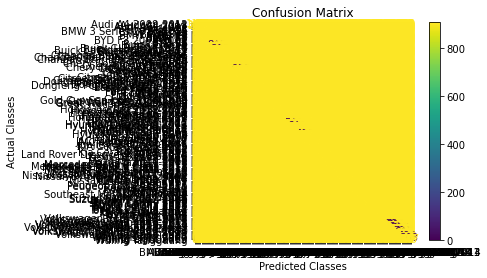

In [21]:
cm.plot(cmap=plt.cm.viridis, number_label=True, plot_lib="matplotlib")

In [22]:
cm

pycm.ConfusionMatrix(classes: ['Audi A4 2009-2012', 'Audi A4 2013', 'Audi A6L 2009', 'Audi A6L 2012', 'Audi A8L', 'Audi Q5', 'Audi Q7', 'BMW 3 Series 2013-2014', 'BMW 5 Series', 'BMW 530', 'BMW 7 Series', 'BMW X1', 'BMW X3', 'BMW X5', 'BYD F0', 'BYD F3 2007-2011', 'BYD F6', 'BYD L3', 'BYD S6', 'Buick Encore', 'Buick Excelle', 'Buick GL8', 'Buick GL8 2011-2013', 'Buick Hideo 2010-13', 'Buick LaCrosse 2009-2013', 'Buick Regal 09-11', 'Buick Yinglang XT', 'Cadillac SRX', "Chang'an Star", 'Changan Star 2 Generation', 'Changan Star 6363 Series', 'Changan Starlight 4500 Series', 'Changan Starlight SC6345BFA', 'Changhe Freda', 'Chery A3 2008', 'Chery A5', 'Chery Cowin 2008 Model', 'Chery E5', 'Chery Fengyun', 'Chery QQ 2007-2012', 'Chery Tiggo 2011 Model', 'Chevrolet Captiva', 'Chevrolet Cruze', 'Chevrolet Epica', 'Chevrolet Lefeng', 'Chevrolet Malibu', 'Chevrolet Sail', 'Citroen C2', 'Citroen C4 2009', 'Citroen C5 2010-2012', 'Citroen Elysee 2008-2013', 'Citroen SEGA 2012', 'Citroen-Elysee-2

In [23]:
sum(P) / len(P)

0.9895614175385495

In [41]:
TP  = sum(cm.TP.values())
TP/29917

0.992579469866631

In [25]:
cm.FP.values()

dict_values([0, 2, 0, 1, 0, 3, 0, 0, 0, 0, 3, 1, 2, 1, 0, 0, 0, 1, 0, 0, 0, 0, 3, 1, 1, 2, 0, 0, 52, 1, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 17, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 1, 0, 0, 5, 0, 0, 0, 1, 0, 0, 0, 0, 0, 13, 0, 0, 0, 0, 1, 0, 1, 4, 0, 1, 0, 0, 0, 0, 5, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 3, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 4, 0, 0, 0, 5, 0, 7, 26, 0, 0, 11, 10, 0, 2, 0, 0, 0, 0, 0])

In [26]:
TN  = sum(cm.TN.values())
TN

5953261

In [27]:
FP = sum(cm.FP.values())
FP

222

In [28]:
FN  = sum(cm.FN.values())
FN

222

In [29]:
acc = (TP+TN) / (TP+FP+FN+TN)
acc

0.9999257946986663

In [30]:
P = TP/(TP+FP)
P

0.992579469866631

In [31]:
R = TP/(TP+FN)
R

0.992579469866631

In [32]:
F1 = 2 * (P*R/(P+R))
F1

0.992579469866631